# Hierarchical Bayesian Neural Networks

Code is based on  [This blog post](https://twiecki.io/blog/2018/08/13/hierarchical_bayesian_neural_network/) by [Thomas Wiecki](https://twitter.com/twiecki).
[Original PyMC3 Notebook](https://github.com/twiecki/WhileMyMCMCGentlySamples/blob/master/content/downloads/notebooks/bayesian_neural_network_hierarchical.ipynb). Converted to Blackjax by Aleyna Kara (@karalleyna) and Kevin Murphy (@murphyk). (For a Numpyro version, see [here](https://github.com/probml/probml-notebooks/blob/main/notebooks/bnn_hierarchical_numpyro.ipynb).)

We create T=18 different versions of the "two moons" dataset, each rotated by a different amount. These correspond to T different nonlinear binary classification "tasks" that we have to solve. We only get a few labeled samples from each each task, so solving them separately (with T independent MLPs, or multi layer perceptrons) will result in poor performance. If we pool all the data, and fit a single MLP, we also get poor performance, because we are mixing together different decision boundaries. But if we use a hierarchical Bayesian model, with one MLP per task, and one learned prior MLP,  we will get better results, as we will see.

Below is a high level illustration of the multi-task setup. $\Phi$ is the learned prior, and $\Theta_t$ are the parameters for task $t$. We assume $N^t=50$ training samples per task, and $M^t=50$ test samples. (We could of course consider more imbalanced scenarios.)


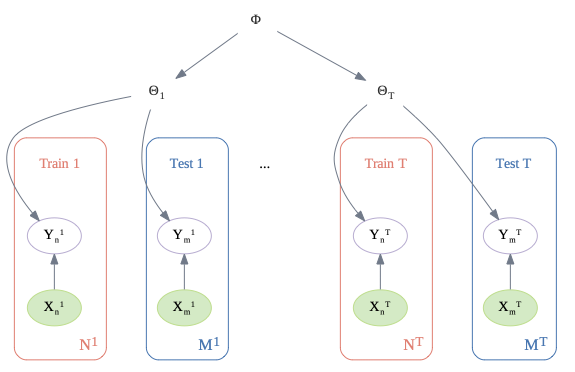


## Setup

In [1]:
from functools import partial
from warnings import filterwarnings

import distrax
from flax import linen as nn
from flax.linen.initializers import ones
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow_probability.substrates.jax.distributions as tfd
from jax import vmap
from jax.random import PRNGKey, split
from sklearn.datasets import make_moons
from sklearn.preprocessing import scale

import blackjax

filterwarnings("ignore")
sns.set_style("white")

cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
cmap_uncertainty = sns.cubehelix_palette(light=1, as_cmap=True)

## Data

We create T=18 different versions of the "two moons" dataset, each rotated by a different amount. These correspond to T different binary classification "tasks" that we have to solve.

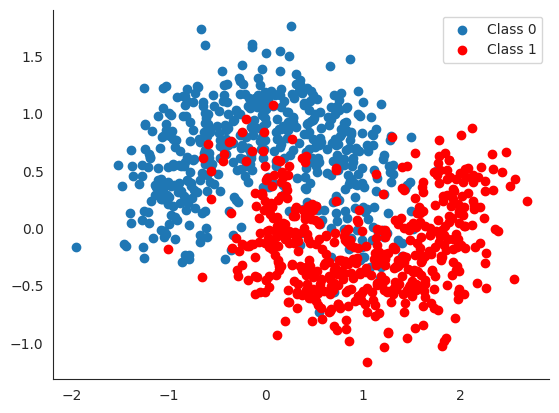

In [2]:
X, Y = make_moons(noise=0.3, n_samples=1000)
plt.scatter(X[Y == 0, 0], X[Y == 0, 1], label="Class 0")
plt.scatter(X[Y == 1, 0], X[Y == 1, 1], color="r", label="Class 1")
sns.despine()
plt.legend();

In [3]:
n_groups = 18

n_grps_sq = int(np.sqrt(n_groups))
n_samples = 100

In [4]:
def rotate(X, deg):
    theta = np.radians(deg)
    c, s = np.cos(theta), np.sin(theta)
    R = np.matrix([[c, -s], [s, c]])

    X = X.dot(R)

    return np.asarray(X)

In [5]:
np.random.seed(31)

Xs, Ys = [], []
for i in range(n_groups):
    # Generate data with 2 classes that are not linearly separable
    X, Y = make_moons(noise=0.3, n_samples=n_samples)
    X = scale(X)

    # Rotate the points randomly for each category
    rotate_by = np.random.randn() * 90.0
    X = rotate(X, rotate_by)
    Xs.append(X)
    Ys.append(Y)

In [6]:
Xs = jnp.stack(Xs)
Ys = jnp.stack(Ys)

Xs_train = Xs[:, : n_samples // 2, :]
Xs_test = Xs[:, n_samples // 2 :, :]
Ys_train = Ys[:, : n_samples // 2]
Ys_test = Ys[:, n_samples // 2 :]

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


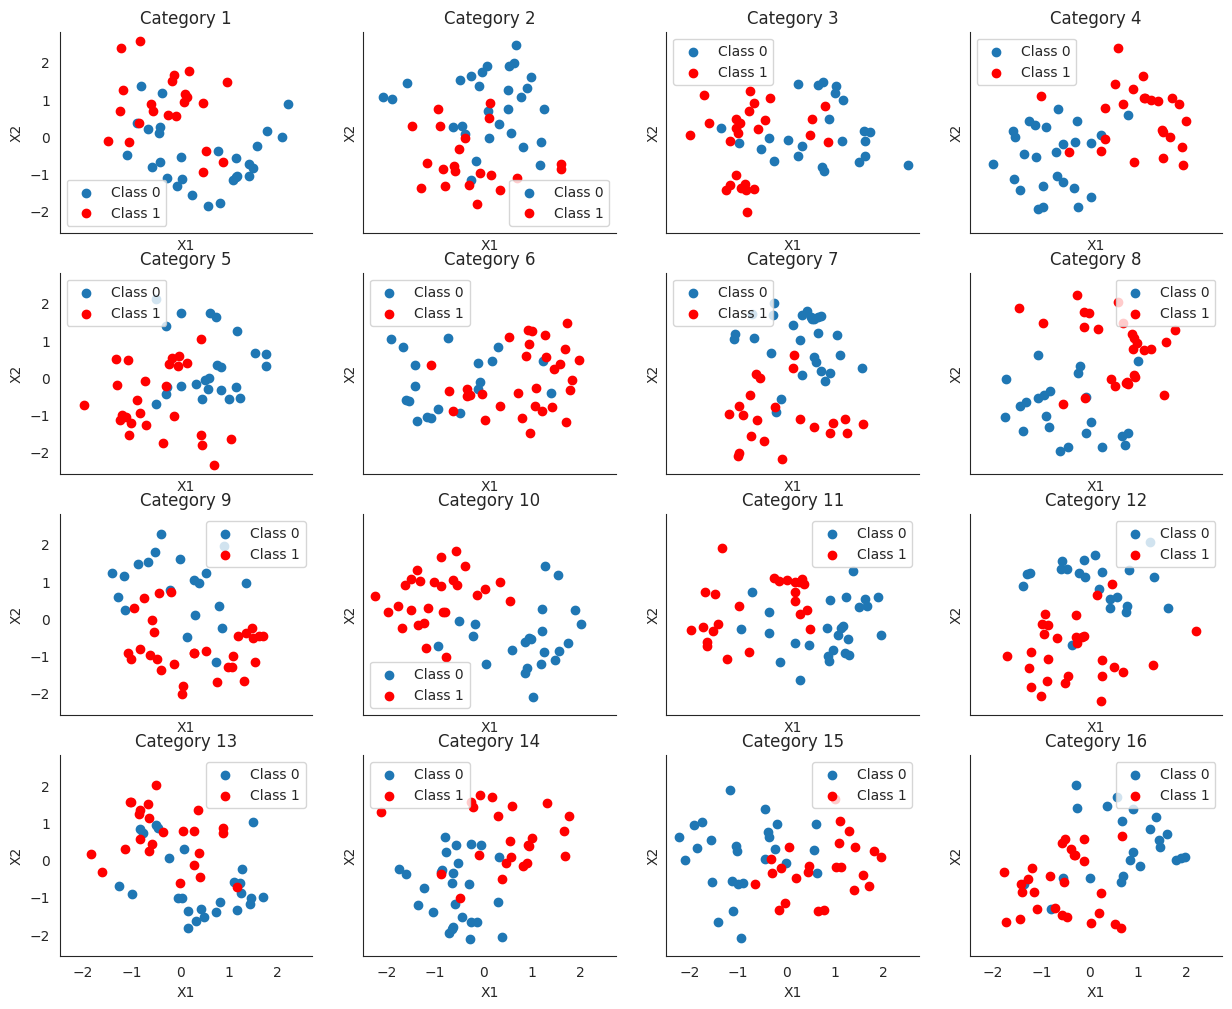

In [7]:
fig, axs = plt.subplots(
    figsize=(15, 12), nrows=n_grps_sq, ncols=n_grps_sq, sharex=True, sharey=True
)
axs = axs.flatten()
for i, (X, Y, ax) in enumerate(zip(Xs_train, Ys_train, axs)):
    ax.scatter(X[Y == 0, 0], X[Y == 0, 1], label="Class 0")
    ax.scatter(X[Y == 1, 0], X[Y == 1, 1], color="r", label="Class 1")
    sns.despine()
    ax.legend()
    ax.set(title=f"Category {i + 1}", xlabel="X1", ylabel="X2")


grid = jnp.mgrid[-3:3:100j, -3:3:100j].reshape((2, -1)).T
grid_3d = jnp.repeat(grid[None, ...], n_groups, axis=0)

## Utility Functions for Training and Testing

In [8]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [9]:
def get_predictions(model, samples, X, rng_key):
    vmap = jax.vmap(model.apply, in_axes=(0, None), out_axes=0)
    z = vmap(samples, X)
    predictions = distrax.Bernoulli(logits=z).sample(seed=rng_key)

    return predictions.squeeze(-1)

In [10]:
def get_mean_predictions(predictions, threshold=0.5):
    # compute mean prediction and confidence interval around median
    mean_prediction = jnp.mean(predictions, axis=0)
    return mean_prediction > threshold

In [11]:
def fit_and_eval(
    rng_key, model, logdensity_fn, X_train, Y_train, X_test, grid, n_groups=None
):
    init_key, warmup_key, inference_key, train_key, test_key, grid_key = split(
        rng_key, 6
    )

    if n_groups is None:
        initial_position = model.init(rng_key, jnp.ones(X_train.shape[-1]))
    else:
        initial_position = model.init(rng_key, jnp.ones(X_train.shape))

    # initialization
    logprob = partial(logdensity_fn, X=X_train, Y=Y_train, model=model)

    # warm up
    adapt = blackjax.window_adaptation(blackjax.nuts, logprob)
    (final_state, params), _ = adapt.run(warmup_key, initial_position, num_warmup)
    kernel = blackjax.nuts(logprob, **params).step
    
    # inference
    states = inference_loop(inference_key, kernel, final_state, num_samples)
    samples = states.position

    # evaluation
    predictions = get_predictions(model, samples, X_train, train_key)
    Y_pred_train = get_mean_predictions(predictions)

    predictions = get_predictions(model, samples, X_test, test_key)
    Y_pred_test = get_mean_predictions(predictions)

    pred_grid = get_predictions(model, samples, grid, grid_key)

    return Y_pred_train, Y_pred_test, pred_grid

## Hyperparameters

We use an MLP with 2 hidden layers, each with 5 hidden units.

In [12]:
# MLP params
hidden_layer_width = 5
n_hidden_layers = 2

In [13]:
# MCMC params

num_warmup = 1000
num_samples = 500

## Fit Separate MLPs, One Per Task

Let $w^t_{ijl}$ be  the weight for node $i$ to node $j$ in layer $l$ in task $t$. We assume
$$
w^t_{ijl} \sim N(0,1)
$$
and compute the posterior for all the weights.

In [14]:
class NN(nn.Module):
    n_hidden_layers: int
    layer_width: int

    @nn.compact
    def __call__(self, x):
        for i in range(self.n_hidden_layers):
            x = nn.Dense(features=self.layer_width)(x)
            x = nn.tanh(x)
        return nn.Dense(features=1)(x)

bnn = NN(n_hidden_layers, hidden_layer_width)

In [15]:
def logprior_fn(params):
    leaves, _ = jax.tree_util.tree_flatten(params)
    flat_params = jnp.concatenate([jnp.ravel(a) for a in leaves])
    return jnp.sum(distrax.Normal(0, 1).log_prob(flat_params))

def loglikelihood_fn(params, X, Y, model):
    logits = jnp.ravel(model.apply(params, X))
    return jnp.sum(distrax.Bernoulli(logits).log_prob(Y))

def logdensity_fn_of_bnn(params, X, Y, model):
    return logprior_fn(params) + loglikelihood_fn(params, X, Y, model)

In [16]:
rng_key = PRNGKey(0)
keys = split(rng_key, n_groups)


def fit_and_eval_single_mlp(key, X_train, Y_train, X_test):
    return fit_and_eval(
        key, bnn, logdensity_fn_of_bnn, X_train, Y_train, X_test, grid, n_groups=None
    )

Ys_pred_train, Ys_pred_test, ppc_grid_single = vmap(fit_and_eval_single_mlp)(
    keys, Xs_train, Ys_train, Xs_test
)

### Results

Accuracy is reasonable, but the decision boundaries have not captured the underlying Z pattern in the data, due to having too little data per task. (Bayes model averaging results in a simple linear decision boundary, and prevents overfitting.)

In [17]:
print(f"Train accuracy = {100 * jnp.mean(Ys_pred_train == Ys_train):.2f}%")

Train accuracy = 87.00%


In [18]:
print(f"Test accuracy = {100 * jnp.mean(Ys_pred_test == Ys_test):.2f}%")

Test accuracy = 81.89%


In [19]:
def plot_decision_surfaces_non_hierarchical(nrows=2, ncols=2):
    fig, axes = plt.subplots(
        figsize=(15, 12), nrows=nrows, ncols=ncols, sharex=True, sharey=True
    )
    axes = axes.flatten()
    for i, (X, Y_pred, Y_true, ax) in enumerate(
        zip(Xs_train, Ys_pred_train, Ys_train, axes)
    ):
        ax.contourf(
            grid[:, 0].reshape(100, 100),
            grid[:, 1].reshape(100, 100),
            ppc_grid_single[i, ...].mean(axis=0).reshape(100, 100),
            cmap=cmap,
        )
        ax.scatter(X[Y_true == 0, 0], X[Y_true == 0, 1], label="Class 0")
        ax.scatter(X[Y_true == 1, 0], X[Y_true == 1, 1], color="r", label="Class 1")
        sns.despine()
        ax.legend()

Below we show that the decision boundaries do not look reasonable, since there is not enough data to fit each model separately.

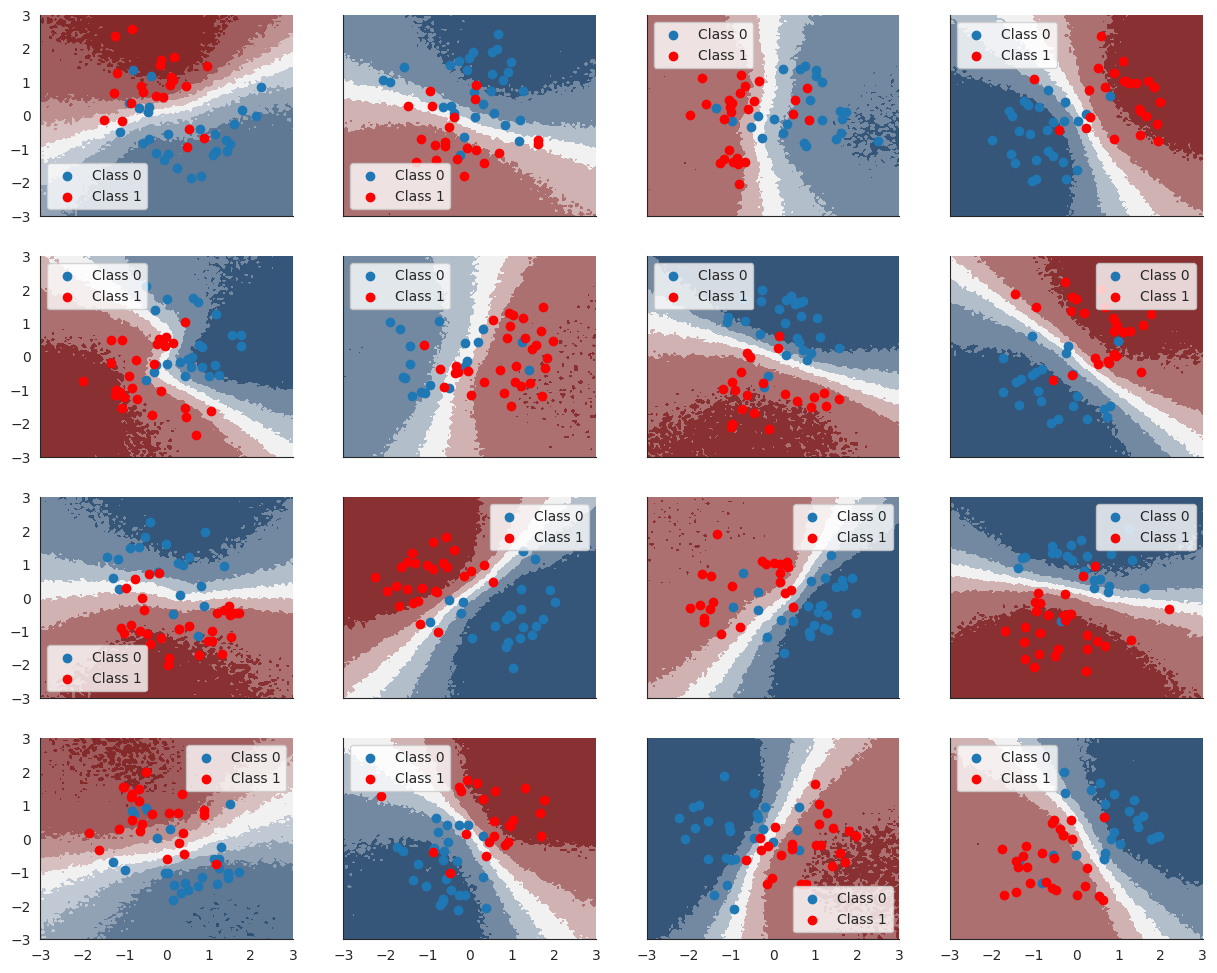

In [20]:
plot_decision_surfaces_non_hierarchical(nrows=n_grps_sq, ncols=n_grps_sq)

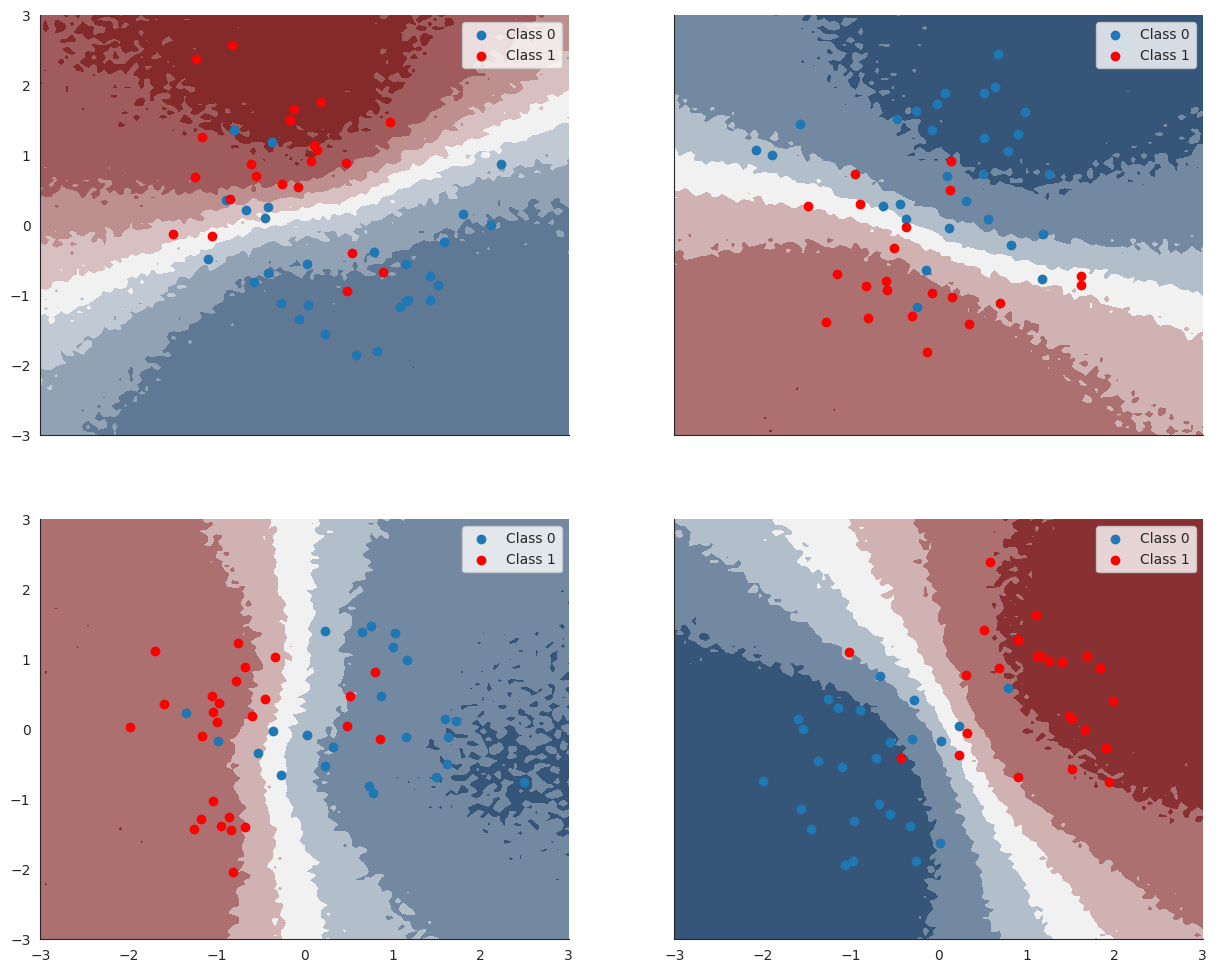

In [21]:
plot_decision_surfaces_non_hierarchical()

## Hierarchical Model

Now we use a hierarchical Bayesian model, which has a common Gaussian prior for all the weights, but allows each task to have its own task-specific parameters. More precisely, let $w^t_{ijl}$ be  the weight for node $i$ to node $j$ in layer $l$ in task $t$. We assume
$$
w^t_{ijl} \sim N(\mu_{ijl}, \sigma_l)
$$

$$
\mu_{ijl} \sim N(0,1)
$$

$$
\sigma_l \sim N_+(0,1)
$$

or, in non-centered form,
$$
w^t_{ijl} = \mu_{ijl} + \epsilon^t_{ijl} \sigma_l
$$

In the figure below, we illustrate this prior, using an MLP with D inputs, 2 hidden layers (of size $L_1$ and $L_2$), and a scalar output (representing the logit).

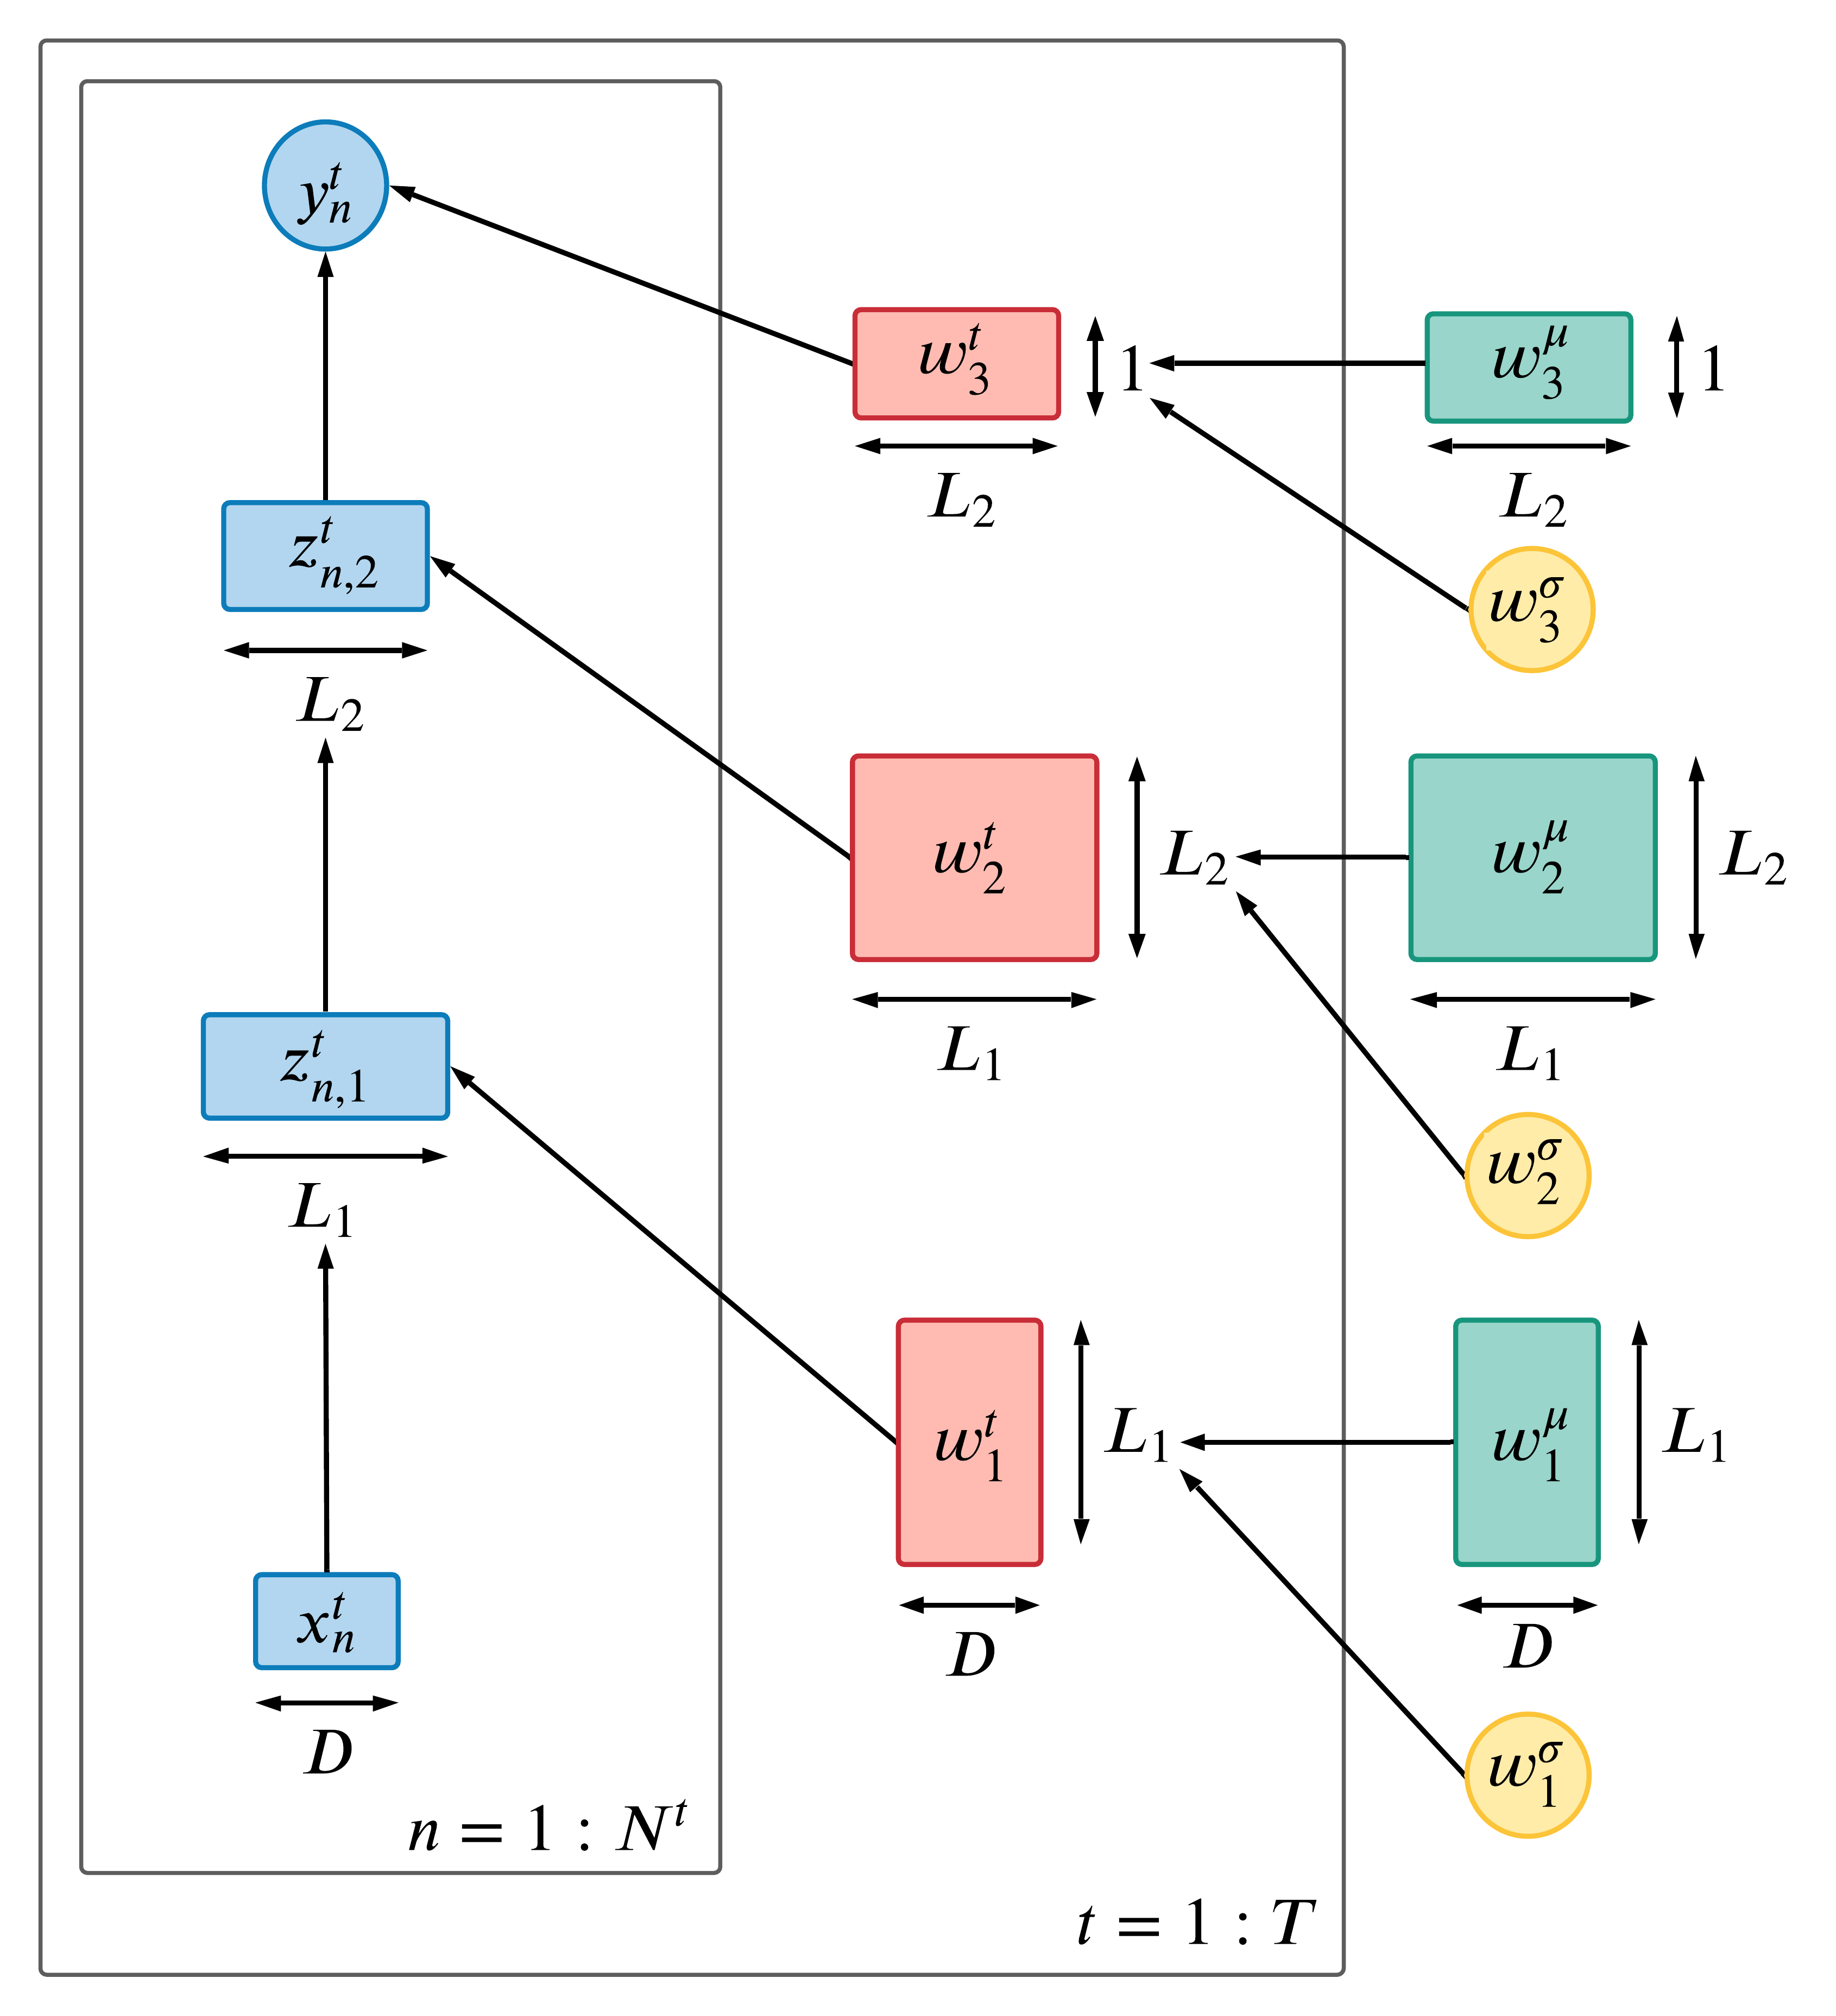

In [22]:
class NonCenteredDense(nn.Module):
    features: int

    @nn.compact
    def __call__(self, x):
        mu = self.param('mu', jax.random.normal, (x.shape[-1], self.features))
        eps = self.param('eps', jax.random.normal, (n_groups, x.shape[-1], self.features))
        std = self.param('std', ones, 1)
        w = mu + std * eps
        return x @ w

class HNN(nn.Module):
    n_hidden_layers: int
    layer_width: int

    @nn.compact
    def __call__(self, x):
        for i in range(self.n_hidden_layers):
            x = NonCenteredDense(features=self.layer_width)(x)
            x = nn.tanh(x)
        return nn.Dense(features=1)(x)

hnn = HNN(n_hidden_layers, hidden_layer_width)

In [23]:
def logprior_fn_of_hnn(params, model):
    lp = 0
    half_normal = distrax.as_distribution(tfd.HalfNormal(1.0))

    for i in range(model.n_hidden_layers):
        lparam = params["params"][f"NonCenteredDense_{i}"]
        lp += distrax.Normal(0.0, 1.0).log_prob(lparam["mu"]).sum()
        lp += distrax.Normal(0.0, 1.0).log_prob(lparam["eps"]).sum()
        lp += half_normal.log_prob(lparam["std"]).sum()
    lp += logprior_fn(params["params"]["Dense_0"])

    return lp

def loglikelihood_fn(params, X, Y, model):
    logits = jnp.ravel(model.apply(params, X))
    return jnp.sum(distrax.Bernoulli(logits).log_prob(jnp.ravel(Y)))

def logdensity_fn_of_hnn(params, X, Y, model):
    return logprior_fn_of_hnn(params, model) + loglikelihood_fn(params, X, Y, model)

In [24]:
%%time

rng_key = PRNGKey(0)
Ys_hierarchical_pred_train, Ys_hierarchical_pred_test, ppc_grid = fit_and_eval(
    rng_key,
    hnn,
    logdensity_fn_of_hnn,
    Xs_train,
    Ys_train,
    Xs_test,
    grid_3d,
    n_groups=n_groups,
)

CPU times: user 1min 59s, sys: 4.77 s, total: 2min 3s
Wall time: 1min 59s


### Results

We see that the train and test accuracy are higher, and the decision boundaries all have the shared "Z" shape, as desired.

In [25]:
print(
    "Train accuracy = {:.2f}%".format(
        100 * jnp.mean(Ys_hierarchical_pred_train == Ys_train)
    )
)

Train accuracy = 90.89%


In [26]:
print(
    "Test accuracy = {:.2f}%".format(
        100 * jnp.mean(Ys_hierarchical_pred_test == Ys_test)
    )
)

Test accuracy = 87.11%


In [27]:
def plot_decision_surfaces_hierarchical(nrows=2, ncols=2):
    fig, axes = plt.subplots(
        figsize=(15, 12), nrows=nrows, ncols=ncols, sharex=True, sharey=True
    )

    for i, (X, Y_pred, Y_true, ax) in enumerate(
        zip(Xs_train, Ys_hierarchical_pred_train, Ys_train, axes.flatten())
    ):
        ax.contourf(
            grid[:, 0].reshape((100, 100)),
            grid[:, 1].reshape((100, 100)),
            ppc_grid[:, i, :].mean(axis=0).reshape(100, 100),
            cmap=cmap,
        )
        ax.scatter(X[Y_true == 0, 0], X[Y_true == 0, 1], label="Class 0")
        ax.scatter(X[Y_true == 1, 0], X[Y_true == 1, 1], color="r", label="Class 1")
        sns.despine()
        ax.legend()

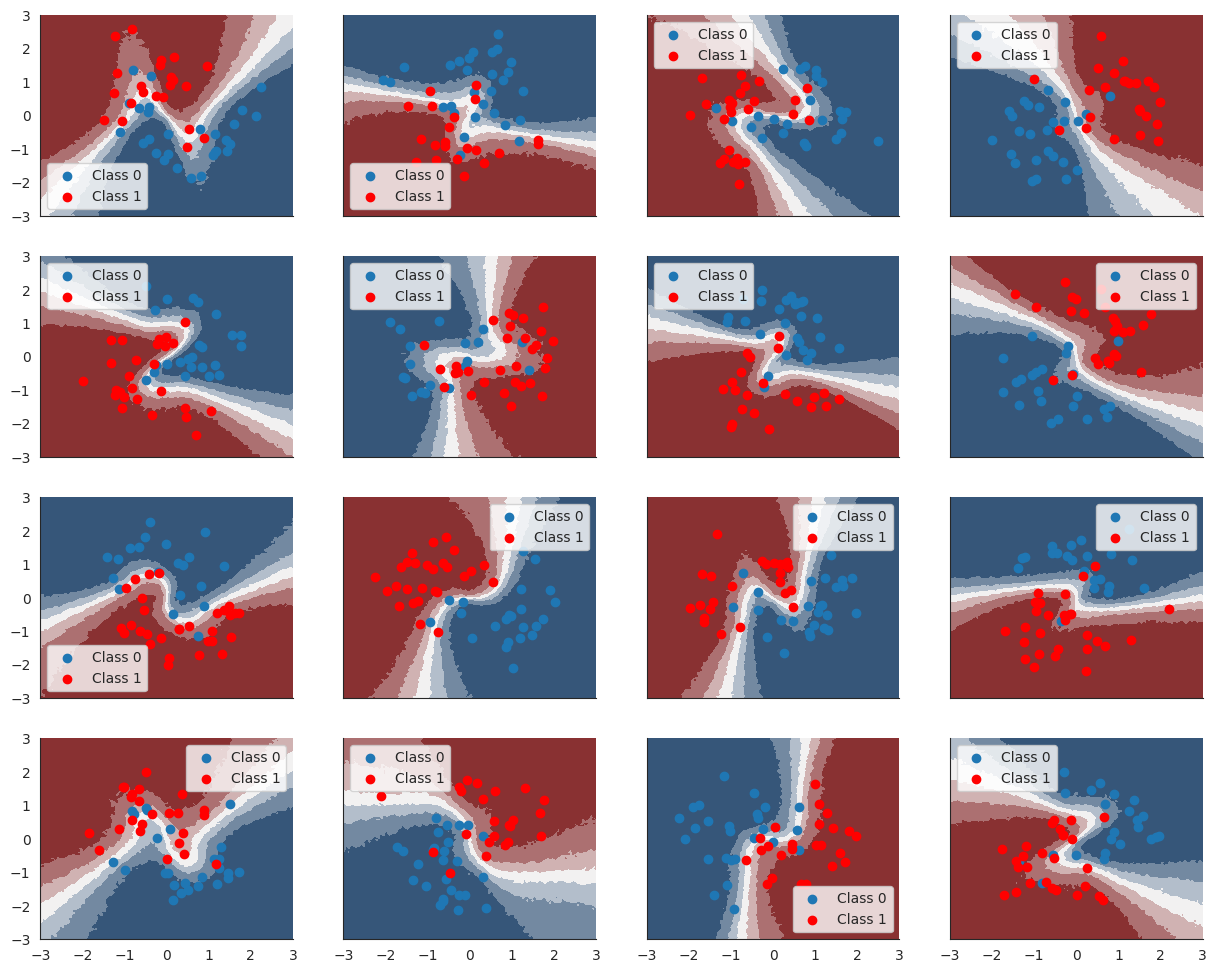

In [28]:
plot_decision_surfaces_hierarchical(nrows=n_grps_sq, ncols=n_grps_sq)

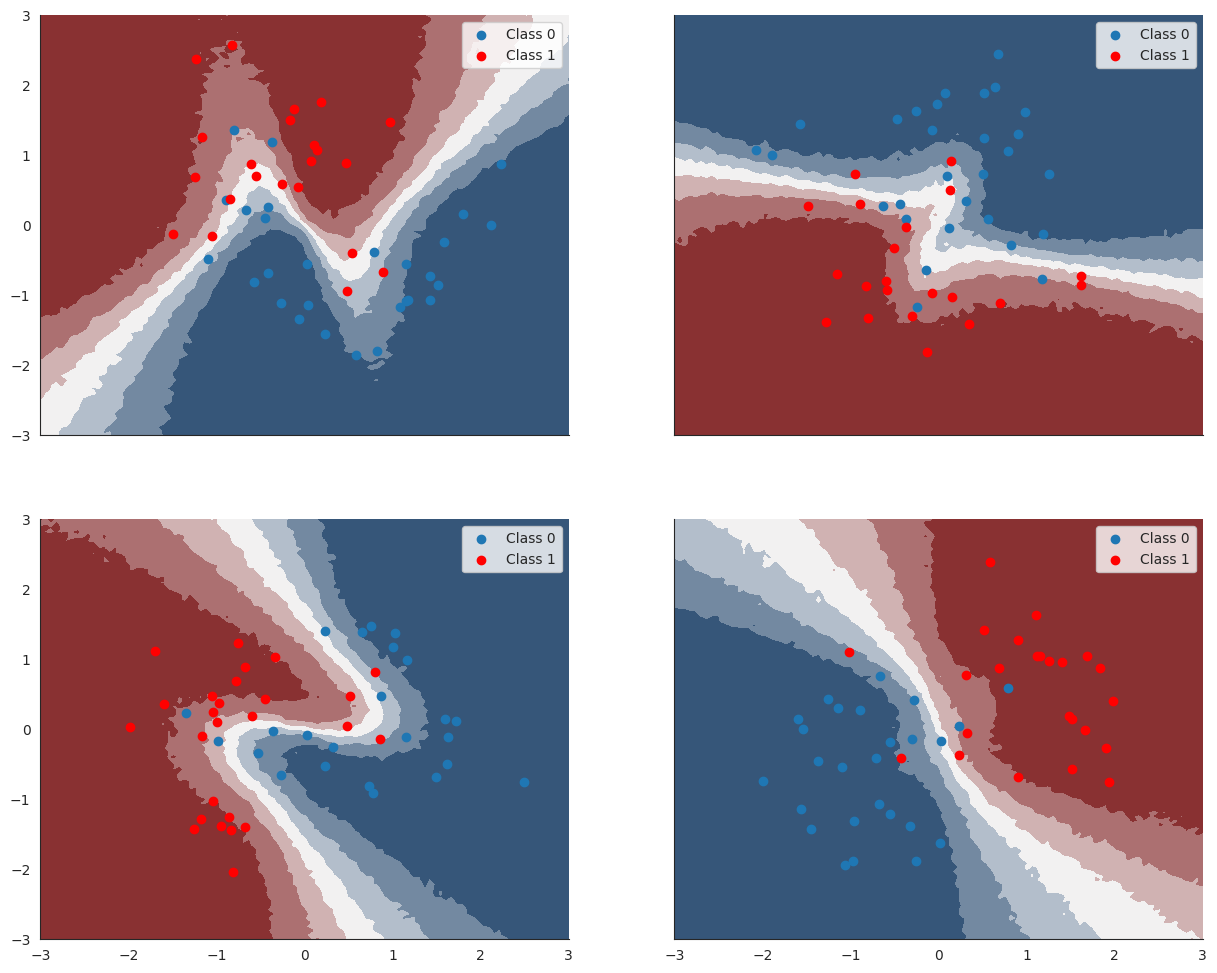

In [29]:
plot_decision_surfaces_hierarchical()